# Model inference II

Based on the variational posterior of the parameter $\beta$ and $\rho$, we aim to have following inference from the model. 

+ Species similarity based on the species specific latent vector $\beta$ (cosine distance used)
+ Identify positive  interaction among species using positive entries in in the interaction matrix $\rho^{T}\beta$
+ Identify negative  interaction among species using negative entries in in the interaction matrix $\rho^{T}\beta$



In [1]:
## call python script to load data and column order
import os
exec(open('data_file.py').read())
# load packages 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pylab as pltx
import seaborn as sns
import pystan
import pickle
import scipy.cluster.hierarchy as sch
import copy
import vb_stan as vbfun
import sub_fun as sf
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.ticker as ticker
import copy 
import random
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import kneighbors_graph
from fa2 import ForceAtlas2
from networkx.algorithms.community import greedy_modularity_communities
import networkx as nx
random.seed(123)
figfol = 'mem_plot/'

plt.rcParams.update(plt.rcParamsDefault)
params = {'legend.fontsize': 12,
          'font.weight': 'bold',
         'axes.labelsize': 12,
         'axes.titlesize':12,
         'axes.labelweight': 'bold',
         'xtick.labelsize':12,
          'axes.titleweight': 'bold',
         #'figure.figsize': (15,8),
          'figure.dpi': 200,
         'ytick.labelsize':12}
plt.rcParams.update(params)

%matplotlib inline
distinct_colp = ["maroon","brown","olive", "teal", "lightgreen", "red", "orange",\
 "yellow", "lime", "green", "cyan", "blue", "purple", "magenta",\
 "grey", "pink", "darkorange", "beige", "slategray", "lavender", "navy",\
     "cornflowerblue","olivedrab",'greenyellow','peru','darkslateblue']
# https://stackoverflow.com/questions/22408237/named-colors-in-matplotlib
# from fa2 import ForceAtlas2

/cm/shared/sw/pkg/devel/python3/3.7.3/lib/python3.7/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


In [2]:
# Call the output from the fitted model:
fname_best = '66_model_nb_cvtest.pkl'
folname = 'MMSens/'
[holdout_mask, llpd, n_test, l,m_seed,sp_mean,\
 sp_var, h_prop, uid, nsample_o, Yte_fit, cv_test] = pickle.load(open(folname + fname_best, "rb"))

# -------------------------------------------------
# save model output 
fname_ot = folname + str(uid) + '_' + 'model_nb.pkl' 
#with open(fname_o, 'wb') as f:
#    pickle.dump(NB_vb, f)
with open(fname_ot, 'rb') as f:
    results = pickle.load(f)
    
sample_fname = folname + str(uid) + '_' + 'sample_model_nb_cvtest.pkl' 
with open(sample_fname, 'rb') as f:
    [Yte_sample,Yte_cv] = pickle.load(f)

parma_mean  = dict(vbfun.vb_extract_mean(results))

/mnt/home/amishra/jobs/microbiome/embeddings/vb_stan.py:57: RuntimeWarning: invalid value encountered in multiply
  params = OrderedDict([(name, np.nan * np.empty(shape)) for name, shape in param_shapes.items()])


In [3]:
## Extract annotation of the microbial species 
tax_name = pd.read_csv('species_tax.csv')
tax_name = tax_name.rename(columns={'Unnamed: 0': 'OTU'})
tax_name = tax_name[1:]
tax_name.insert(0, 'Id', tax_name['OTU'].str[3:])
tax_name.columns.values[1] = 'Label'
tax_name.to_csv('node_otu.csv', index = False) 
temx = tax_name.iloc[:,:8]
temx = temx.replace(np.nan,'')
species_name = []
# Add taxonomy identifier to the each of the species name 
for i in range(temx.shape[0]):
    a = temx.iloc[i,:].values
    for j in range(a.shape[0]-1,-1,-1):
        if len(a[j]) > 0:
            species_name.append(temx.columns[j][0].lower()+'_'+ a[j])
            break;           
species_name = np.array(species_name)  
tax_name['Name'] = species_name
# tax_name['ord_abu'] = np.linspace(10,1,tax_name.shape[0])[(-1*Y.mean(axis=0)).argsort()]
tax_name['Abundance'] = Y.sum(axis=0)
tax_name[['Id']] = tax_name[['Id']].values.astype(np.int64)
tax_name = tax_name.replace(np.nan,'Empty')
tem = pd.read_csv('species_tax_anot.amended.csv').iloc[:,[1,12]]
tax_name = tax_name.merge(tem,on = 'Label')
tax_name = tax_name.rename(columns={"Ecologically_relevant_classification_aggregated": "ECR"})

## Update the new annotation in the
i = 11    # index for ECR variable 
ind_var = tax_name.iloc[:,i].values
vals, counts = np.unique(ind_var, return_counts=True)
tem_ind1 = (-1*counts).argsort()
tem_val = vals[tem_ind1][range(np.min([np.sum(counts > 10),tem_ind1.shape[0]]))]
tmp = np.setdiff1d(np.unique(ind_var), tem_val)
import sub_fun as sf
tmp = sf.return_indices_of_a(tmp, ind_var)
ind_var[tmp] = "Other" 
tax_name.iloc[:,i] = ind_var


<font color=blue>**Perform the softmax regression based on the latent characteristic of the species specific parameters $\beta$** </font>

 - Here our aim is to find subset of 1378 species that are efficiently charcterized in terms of the species specific latent vector $\beta$. 

In [4]:
## Prepare response matrix for softmax regression 
tax_name2 = copy.copy(tax_name) 
encode_dict = [[val,i] for i,val in enumerate(np.unique(tax_name2['ECR'].values)) ]
ord_enc = OrdinalEncoder()
ord_enc.fit(tax_name2['ECR'].values.reshape(-1,1))
tax_name2["ECR_code"] = ord_enc.fit_transform(tax_name2['ECR'].values.reshape(-1,1))
cat_val = tax_name2["ECR_code"].values.astype(np.int)


sp_feature = parma_mean['L_sp']   
#sp_feature = np.concatenate((parma_mean['L_sp'], parma_mean['C_geo']), axis = 1)
softReg = LogisticRegressionCV(random_state=10, multi_class = 'multinomial', max_iter = 2000)
clf = softReg.fit(sp_feature, cat_val)
cat_pred = clf.predict(sp_feature)
tax_name2["ECR_pred"]  = ord_enc.inverse_transform(cat_pred.reshape(-1,1))

/cm/shared/sw/pkg/devel/python3/3.7.3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


In [5]:
# Show confusion matrix and present the 
confusion_matrix = pd.crosstab(tax_name2['ECR'], tax_name2["ECR_pred"],\
                               rownames=['Actual'], colnames=['Predicted'],\
                                   dropna = False, normalize = 'index')
# fig, ax = plt.subplots(figsize=(15, 10))
# sns.heatmap(confusion_matrix, annot=True, ax = ax, fmt = '')

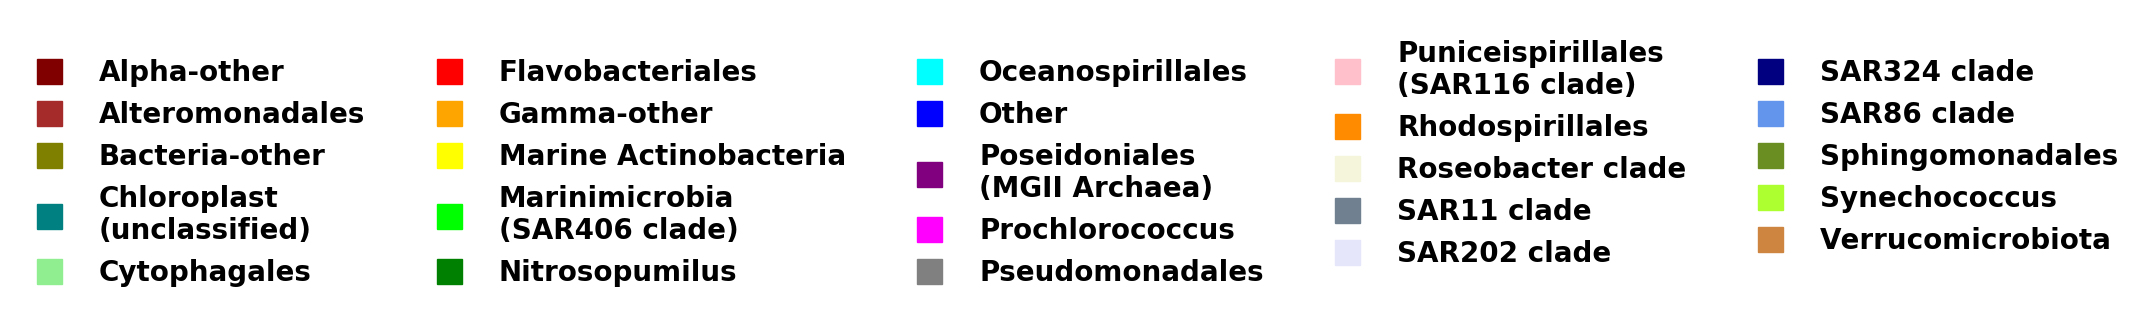

In [6]:
## Select species that are efficiently characterized in terms of the latent parameter $\beta$
## selected_species = [i for i in list(confusion_matrix.columns) if confusion_matrix.loc[i,i] >= 0.00]
selected_species = list(np.unique(tax_name2['ECR']))
#selected_species.remove('Other')
selected_species_index = tax_name['ECR'].isin(selected_species).values
species_col_dict = dict(zip(selected_species,distinct_colp[:len(selected_species)]))
f = lambda m,c: plt.plot([],[],marker=m, color=c, ls="none")[0]
label = [i.replace(' (', '\n(') for i in selected_species]   
fig, ax  = plt.subplots(dpi = 100, figsize = (25,4))
handles = [f("s", species_col_dict[i]) for i in selected_species]
plt.legend(handles, label, loc=4, framealpha=1, frameon=False, ncol=5,markerscale=3., fontsize=18,  prop={'size': 20})
plt.gca().set_axis_off()
plt.show()
fig.savefig(figfol + 'MI2Anot.png')

### <font color=blue>Similarity among speecies </font>

+ K nearest neighbour graph to show similarity among species 
+ Modularity analysis to mark cluster of species and efficiently depicts their groupings

In [7]:
## Prepare k-nearest neighbour graph 
def most_important(G,n_sel):
    ranking = nx.betweenness_centrality(G).items()
    ranking = sorted(list(ranking),key=lambda x: x[1], reverse=True)
    nodes_sel = [ranking[i][0] for i in range(n_sel)]
    Gt = g.subgraph(nodes_sel)
    return Gt

#tax_name3 = tax_name[tax_name['ECR'].isin(selected_species)]
tax_name3 = copy.copy(tax_name)
tax_name3['Id'] =  tax_name3['Label']
tax_name3 = tax_name3[selected_species_index]
#tax_name3.to_csv('Species_annotate_new.csv',index=False)

## Select species based on #k = 10# neares neighbour and see graph 
sp_feature = parma_mean['L_sp'][selected_species_index] 
#sp_feature = np.concatenate((parma_mean['L_sp'], parma_mean['C_geo']), axis = 1)[selected_species_index] 

dist = kneighbors_graph(sp_feature, 10, mode='distance', metric = "cosine",
                        include_self=False).toarray()
node_id = tax_name3['Label'].values
species_selected = pd.DataFrame()
for i in range(dist.shape[0]):
    a = np.where(dist[i] != 0.)[0]
    if a.shape[0] > 0:
        d = {'Id': node_id[i],'Source': node_id[i], 'Target': node_id[a],\
         'Type' : 'Undirected', 'Weightx': 1,\
         'weight': 1.0 } # dist[i][a]
        species_selected = species_selected.append(pd.DataFrame(data=d))
# sanity check
# species_selected.to_csv('edge_cosinedist_splatent.csv', index = False)
species_selected = pd.merge(species_selected, tax_name3, on='Id')
tax_name3['color'] = [species_col_dict[n] for n in tax_name3['ECR'].values]

## Prepare node attribute for the networkx plot
node_atr = {}
for i in range(tax_name3.shape[0]):
    node_atr[tax_name3['Id'].values[i] ] = tax_name3.iloc[i,1:].to_dict()
    
np.random.seed(1234)
out = species_selected
g = nx.from_pandas_edgelist(out, source='Source', target='Target',\
                             edge_attr = 'weight',\
                             create_using=nx.Graph()) 
nx.set_node_attributes(g, node_atr)
deg = g.degree()
to_keep = [n for (n, a) in deg if a > 0]
g_sub = g.subgraph(to_keep)


### Detect communities in the network
Here we detect a community in the network and get the subgraph with only subset of OTUS. 

In [8]:
# Modularity analysis to identify community 
random.seed(123)
comunity = list(greedy_modularity_communities(g_sub, weight = 'weight'))
# transformation of community into dictionary 
comunity2 = {}
for i in range(len(comunity)):
    comunity2.update({tem:i for tem in list(comunity[i])})
    
markers_type = ['o', 'v', '^', 's', 'D' ,'X', '<', '>', '8', 'p', '*', 'h',\
                'H', 'd', 'P', '+', '1', '2', '3', '4']

# Attribute     
for n in list(g_sub):
    g_sub.nodes[n]['c_id']  =  comunity2[n]


pickle.dump(comunity2, open('ERC_community.pkl', 'wb'))

In [9]:
# get_subgraph with top 3 OTU in each community; 
# Also discard some of the less abundant community 

## Identify modules 
def group_summary(otu_sel,g_def,top_c,m_t, a):
    temp = [g_def.nodes[n]['ECR'] for n in list(otu_sel)]
    typ, ct = np.unique(temp, return_counts=True)
    sel = typ[ct.argsort()[-top_c:]]
    for n in list(otu_sel):
        g_def.nodes[n]['alp'] = 0.02
        g_def.nodes[n]['mtype'] = m_t#'.'
        g_def.nodes[n]['nlab'] = None
        g_def.nodes[n]['n_size'] = 0.02
        if any(sel == g_def.nodes[n]['ECR']):
            g_def.nodes[n]['alp'] = 0.9 
            g_def.nodes[n]['mtype'] = m_t
            g_def.nodes[n]['nlab'] = a
            g_def.nodes[n]['n_size'] = 1.0
            
## Show top 3 species in each module 
top_c = 5
for i in range(len(comunity)):
    #print(len(comunity[i]))
    group_summary(comunity[i],g_sub,top_c,markers_type[i],i)
    
otu_sub = [n for n in list(g_sub) if g_sub.nodes[n]['nlab'] != None]
g_sub_c = g_sub.subgraph(otu_sub)
## identify community with smaller size
val, count = np.unique([g_sub_c.nodes[n]['c_id'] for n in list(g_sub_c)],return_counts = True)
se1_cid = val[count>10]
otu_sub = [n for n in list(g_sub_c) if any(g_sub_c.nodes[n]['c_id'] == se1_cid)]
g_sub_c = g_sub.subgraph(otu_sub)

Assign community_id to each of the otu 
OTU_attribute alp: set high for the selected OTU 
set edge attribute: iterate over edge; if any of the OTU involved do not have community id modify both edge width and edge alpha 

In [10]:
otu_drop = [n for n in list(g_sub) if g_sub.nodes[n]['nlab'] == None]
for u,v in g_sub.edges():
    g_sub[u][v]['walp'] = 1.0
    g_sub[u][v]['ewidth'] = 1.0
    if (u in otu_drop) or (v in otu_drop):
        g_sub[u][v]['walp'] = 0.1
        g_sub[u][v]['ewidth'] = 0.1
        

### Prepare layout for visualization
##### Layout for full network and community network

In [11]:
## Use ForceAtlas2 layout for the networkx plot
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=True,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=2.0,
                        strongGravityMode=False,
                        gravity=1.0,

                        # Log
                        verbose=True)

random.seed(123)
positions = forceatlas2.forceatlas2_networkx_layout(g_sub, pos=None, iterations=2000)
layout_flip = positions# {node: (x,-y) for (node, (x,y)) in layout.items()}
layout_flip_c = {n:layout_flip[n] for n in otu_sub}

100%|██████████| 2000/2000 [00:52<00:00, 37.81it/s]

BarnesHut Approximation  took  41.14  seconds
Repulsion forces  took  9.75  seconds
Gravitational forces  took  0.12  seconds
Attraction forces  took  0.32  seconds
AdjustSpeedAndApplyForces step  took  0.69  seconds


##### Layout for identified community network

/cm/shared/sw/pkg/devel/python3/3.7.3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


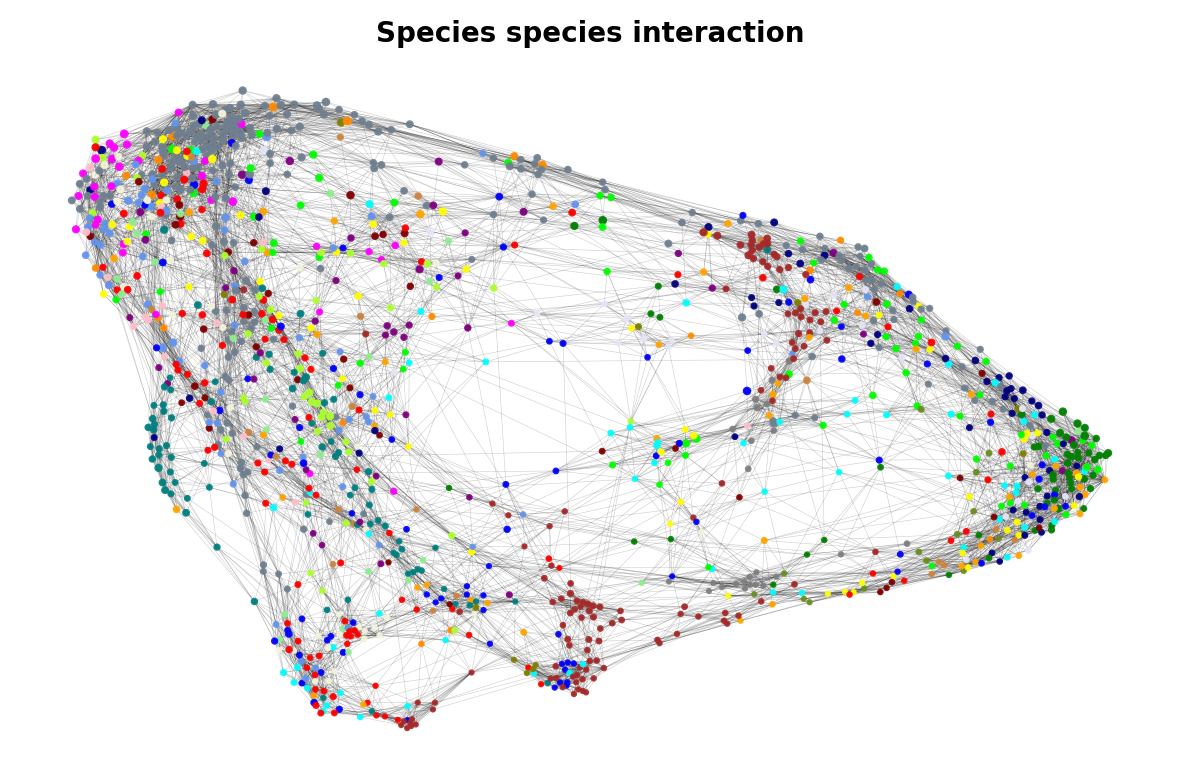

In [12]:
## Draw network plot 
n_size =  [np.log(g_sub.nodes[club]['Abundance']/139.0) for club in list(g_sub)]
widths_n = weights = 2*np.array([g_sub[u][v]['weight'] for u,v in g_sub.edges()])
colors2 = [g_sub.nodes[n]['color']  for n in list(g_sub) ]

fnamex = figfol + 'species_interaction_mat1.pdf'
fig, ax  = plt.subplots(dpi = 200)
nx.draw_networkx_edges(g_sub, layout_flip, width=0.1*widths_n, alpha=0.2, ax =ax)
nc = nx.draw_networkx_nodes(g_sub, 
                       layout_flip, 
                       nodelist=list(g_sub), 
                       node_size= 1*np.array(n_size), 
                       ax = ax,alpha = 0.9,
                       node_color=colors2)
ax.axis('off')
ax.set_title("Species species interaction", fontsize = 10)
fig.tight_layout()
fig.savefig(figfol + 'MI2SPS1.png')

/cm/shared/sw/pkg/devel/python3/3.7.3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


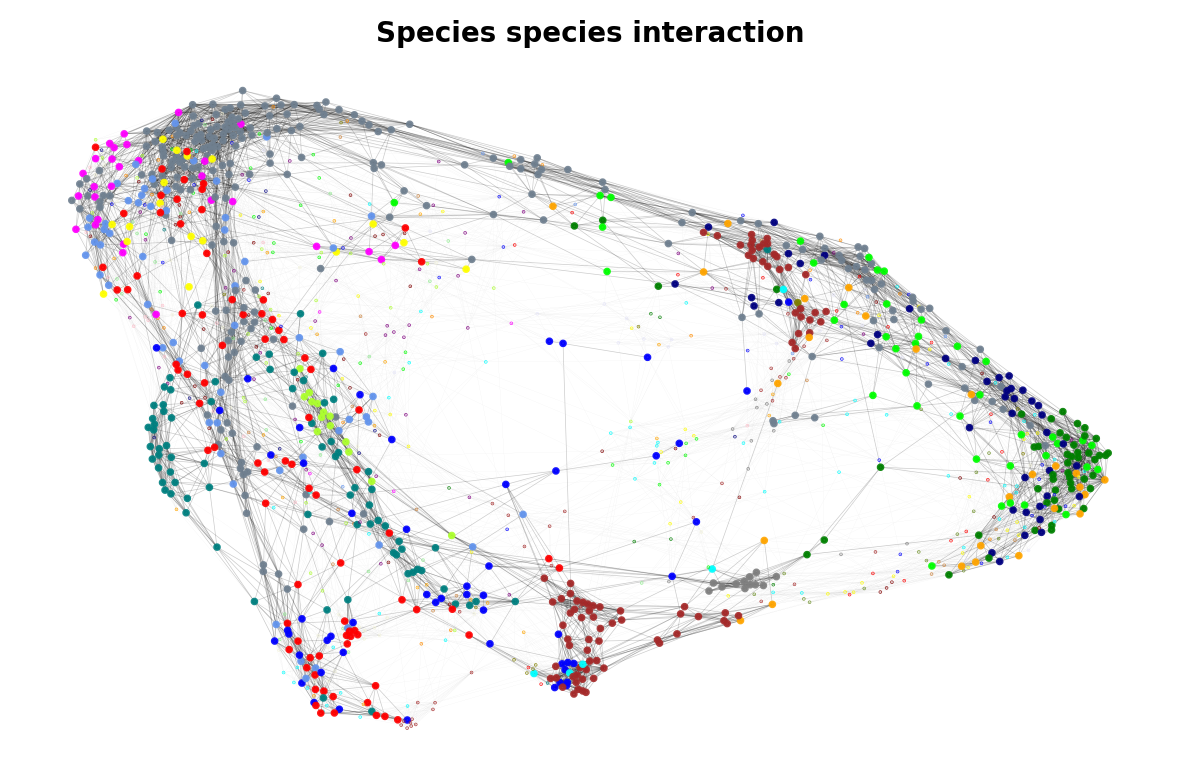

In [13]:
## Draw network plot 
n_size =  [g_sub.nodes[n]['n_size'] for n in list(g_sub)]
n_alp =   [g_sub.nodes[n]['alp'] for n in list(g_sub)]
colors2 = [g_sub.nodes[n]['color']  for n in list(g_sub) ]

e_widths = 0.25*np.array([g_sub[u][v]['ewidth'] for u,v in g_sub.edges()])
e_alp = np.array([g_sub[u][v]['walp'] for u,v in g_sub.edges()])


fnamex = figfol + 'species_interaction_mat1.pdf'
fig, ax  = plt.subplots(dpi = 200)
nx.draw_networkx_edges(g_sub, layout_flip, width=e_widths, alpha=0.2, ax =ax)
nc = nx.draw_networkx_nodes(g_sub, 
                       layout_flip, 
                       nodelist=list(g_sub), 
                       node_size= 3*np.array(n_size), 
                       ax = ax,alpha = 0.9,
                       node_color=colors2)
ax.axis('off')
ax.set_title("Species species interaction", fontsize = 10)
fig.tight_layout()
fig.savefig(figfol + 'MI2SPS1.png')

<font color=blue>**Detect communities and highlight top species in each community. We have heilighted 807 species.**</font>

/cm/shared/sw/pkg/devel/python3/3.7.3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


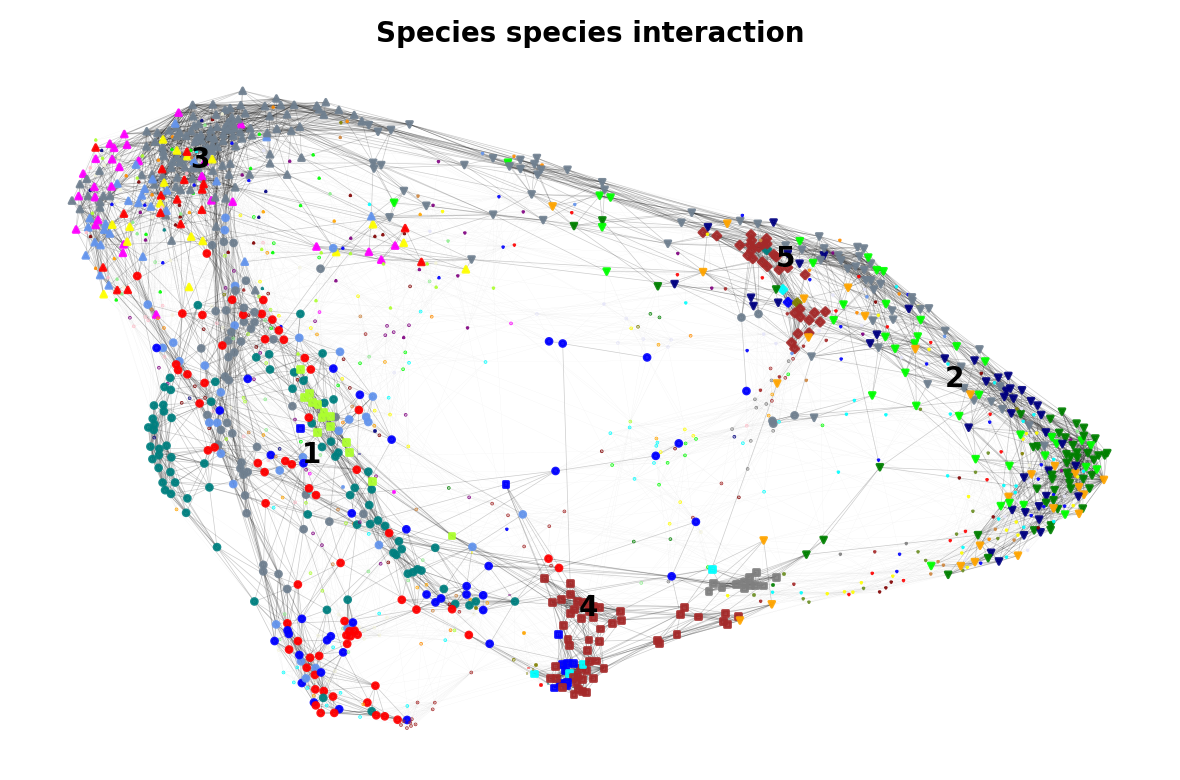

In [18]:
## Draw network plot 
from scipy.spatial import ConvexHull
n_size =  [g_sub.nodes[n]['n_size'] for n in list(g_sub)]
n_alp =   [g_sub.nodes[n]['alp'] for n in list(g_sub)]
colors2 = [g_sub.nodes[n]['color']  for n in list(g_sub) ]

e_widths = 0.25*np.array([g_sub[u][v]['ewidth'] for u,v in g_sub.edges()])
e_alp = np.array([g_sub[u][v]['walp'] for u,v in g_sub.edges()])
mtype = np.array([g_sub.nodes[n]['mtype'] for n in list(g_sub)])

fig, ax  = plt.subplots(dpi = 200)
for m_t in np.unique(mtype):
    sel_ind = np.where(mtype == m_t)
    nc = nx.draw_networkx_nodes(g_sub, 
                           layout_flip, 
                           nodelist= [list(g_sub)[i] for i in sel_ind[0]], 
                           node_size= 4.5*np.array(n_size)[sel_ind], 
                           ax = ax, alpha = 0.9,
                           node_shape = m_t,
                           node_color= [colors2[i] for i in sel_ind[0]])
    clust_cord = np.array([list(layout_flip[list(g_sub)[i]]) for i in sel_ind[0] if (list(g_sub)[i] in otu_sub)])
    xc, yc = np.median(clust_cord, axis = 0)
    val, cnt = np.unique(np.array(colors2)[sel_ind[0]], return_counts = True)
    hull = ConvexHull(clust_cord)
#     ax.fill(clust_cord[hull.vertices,0], clust_cord[hull.vertices,1], val[cnt.argsort()][-1], alpha=0.05)
    ax.text(xc, yc, str(comunity2[list(g_sub)[sel_ind[0][0]]] + 1) , fontsize=10)
#     for simplex in hull.simplices:
#         ax.plot(clust_cord[simplex, 0], clust_cord[simplex, 1], 'k-', lw = 1, alpha = 0.5)
    
nx.draw_networkx_edges(g_sub, layout_flip, width=e_widths, alpha=0.2, ax =ax)
ax.axis('off')
ax.set_title("Species species interaction", fontsize = 10)
fig.tight_layout()
fig.savefig(figfol + 'MI2SPSx.png', dpi = 200)

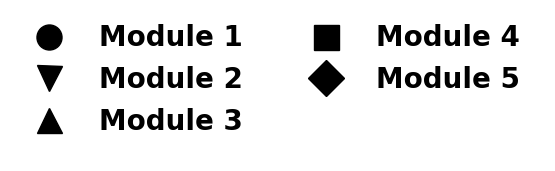

In [15]:
marker_dict = dict(zip(range(len(comunity)),markers_type[:len(comunity)]))
f = lambda m,c: plt.plot([],[],marker=m, color=c, ls="none")[0]
label = [ 'Module ' + str(i+1) for i in marker_dict.keys()]   
fig, ax  = plt.subplots(dpi = 100, figsize = (6,2))
handles = [f(marker_dict[i], 'black') for i in marker_dict.keys()]
plt.legend(handles, label, loc=4, framealpha=1, frameon=False, ncol=2,markerscale=3., fontsize=18,  prop={'size': 20})
plt.gca().set_axis_off()
plt.show()
fig.savefig(figfol + 'temp.png')

In [16]:
len(otu_sub)

825

### Prepare the table for the cluster and its properties 
We report top 3 OTUs in each cluster and report its characteristic. 

Draw legend for the plot and table of summary; [Community id, Top species, Counts, Name, Mean Abundance]

In [17]:
Summary_clust  = [[g_sub_c.nodes[n]['c_id']+1, g_sub_c.nodes[n]['ECR'], g_sub_c.nodes[n]['Abundance'] ] for n in list(g_sub_c)]
Summary_clust = pd.DataFrame(Summary_clust)
Summary_clust.columns = ['ClusterIndex', 'ECR', 'TotalAbundance']
Summary_clust = Summary_clust[['ClusterIndex', 'ECR', 'TotalAbundance']].groupby(['ClusterIndex', 'ECR']).agg(['sum', 'count']).reset_index()
Summary_clust.columns = ['ClusterIndex', 'ECR', 'MeanAbundance','OTU(Count)']
Summary_clust['MeanAbundance'] = Summary_clust['MeanAbundance']/(139.0*Summary_clust['OTU(Count)'])
Summary_clust = Summary_clust.round(2).sort_values(by=['ClusterIndex','OTU(Count)' ], ascending=[True, False])
Summary_clust.iloc[:,3] = np.round(100.0*Summary_clust.iloc[:,3]/np.sum(Summary_clust.iloc[:,3]),2)
Summary_clust.to_csv('clust_sumary.csv', index = False)
Summary_clust

,ClusterIndex,ECR,MeanAbundance,OTU(Count)
0,1,Chloroplast (unclassified),12.49,9.09
1,1,Flavobacteriales,11.00,8.00
3,1,SAR11 clade,19.44,5.94
2,1,Other,10.77,5.09
4,1,SAR86 clade,18.91,3.88
8,2,SAR11 clade,18.67,8.48
7,2,Nitrosopumilus,23.03,6.06
9,2,SAR324 clade,15.48,5.09
6,2,Marinimicrobia (SAR406 clade),16.69,4.97
5,2,Gamma-other,11.13,3.15
